# SVM Poisoning Attack.

## Introduction

Support Vector Machines (SVMs) are a popular type of machine learning algorithm used in many applications, including image classification, natural language processing, and anomaly detection. However, like many machine learning algorithms, SVMs are vulnerable to attacks that manipulate their training data.

One such attack is called a poisoning attack, where an attacker adds malicious data to the training set with the goal of manipulating the SVM's decision boundary. Poisoning attacks can be targeted, where the attacker wants the SVM to classify specific inputs incorrectly, or untargeted, where the attacker just wants to reduce the SVM's overall accuracy.

***

## Outline

In this lab, we will explore the effects of a poisoning attack on an SVM trained on a dataset of handwritten digits. We will use a simple gradient ascent algorithm to craft poison samples that can fool the SVM into misclassifying digits. We will evaluate the effectiveness of the attack by measuring the SVM's accuracy on a test set with and without the poison samples.

By the end of this lab, you will have a better understanding of how SVM poisoning attacks work and how to defend against them. You will also gain experience working with SVMs and gradient ascent algorithms in Python.


### Contents
- [Part 0: Getting Started](#part0)
- [Part 1: Load The Data](#part1)
- [Part 2: Explore The Data](#part2.0) <br/>
  [2.1: Overview of data and features](#part2.1) <br/>
<!--   [2.2: Numerical and categorical features](#part2.2) <br/> -->
- [Part 3: Machine Learning](#part3.0) <br/>
  [3.1: Data Processing](#part3.1) <br/>
  [3.2: SVM Model Training](#part3.2) <br/>
  [3.3: Prediction](#part3.3) <br/>
- [Part 4: Poisoning Attack](#part4.0) <br/>
  [4.1: Classification report](#part4.1) <br/>
<!--   [4.2: Training machine learning model for binary classification](#part4.2) <br/> -->
  [4.2: Generating Poisoning samples](#part4.2)
- [Part 5: Defence against Poisoning Attack](#part5.0) <br/>






<a id='part0'></a>
# Part 0: Getting Started

### Imports and Formatting
**Sci-kit learn (sklearn)** is a commonly used python machine learning library that features various classification, regression and clustering algorithms and powerful data pre and post processing and evaluation methods.

We use the datasets from sci-kit learn to import **MNIST** dataset. (Handwritten images of numbers).

**Pandas** is a data processing and manipulation module used in python which can read various files and augment the data

**Numpy** is a mathematical library that supports multi-dimensional arrays and matrices and high-level math functions

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import importlib
from models.model import ScikitlearnClassifierSVC
from poisoning import PoisoningAttackSVM

C:\Users\Siddharth\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='part1'></a>
# Part 1: Load the Data

MNIST dataset consist of training set: 60,000 samples, test set: 10,000

The images are 28X28 black and white handwritten digits from 0-9.

In [2]:
mnist = fetch_openml('mnist_784')

C:\Users\Siddharth\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Add the following line into the **TODO** section of code cell below to read in required columns/features.

```python
X,y = mnist["data"],mnist["target"]
```
X will contain the pixels data, y will contain the number (target).

In [4]:
#Initialise X,Y 
#TODO


X=np.array(X)
y=np.array(y)
y=y.astype(np.uint8)

<a id='part2.0'></a>
# Part 2: Explore the Data

<a id='part2.1'></a>
### 2.1 Overview of data and features

We explore our data to get an overview of our dataset and to answer questions such as <br/>
How many rows and columns does the dataset contain? <br/>
How can the data be visualised? <br/>


To get the number of rows and columns, use the following line to fill the **TODO** section.

Find the shape of both X , y.
```python
X.shape
```


In [6]:
#List the dimension of our input 'X'array
#TODO

(70000, 784)

In [7]:
#List the dimension of our digit 'Y' array
#TODO


(70000,)


**To visualise the data we use matplotlib library.**

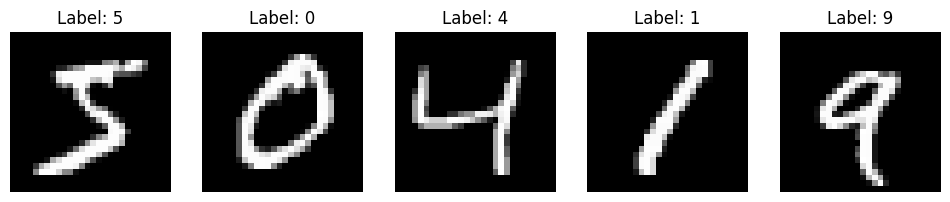

In [8]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    ax = axes[i]
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title('Label: {}'.format(y[i]))
plt.show()

<a id='part3.0'></a>
# Part 3: Machine Learning

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss, accuracy_score

SVM is considered one of the most used ML algorithm in classification. Its application is widely known in spam detection, image classification, malware detection. Its main ability is in differentiating linear data as well as non-linear data, i.e by kernelisation.

In the below diagram, we have 2-D data plot, SVM can easily differentiate this kind of linear data as shown in the plot.

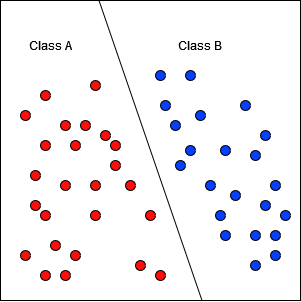

What if the data is mixed up and not linear?

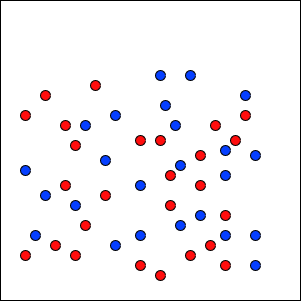

In these case SVM is of rescue. It has a property called Kernelisation, that transforms the dimension of data for easy and faster classification.

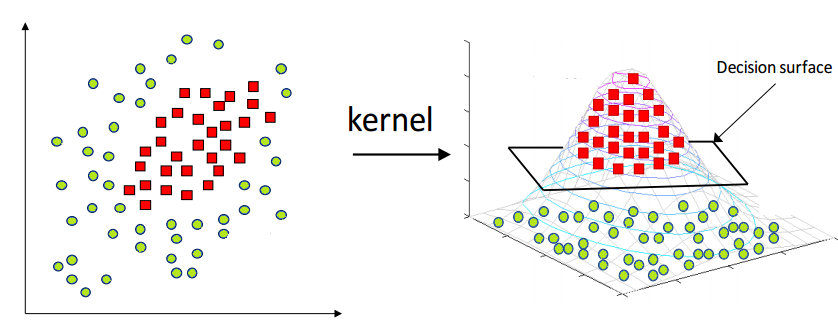


(Reference: https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d)

 Copy the following code into the code cell below to build the SVM model.

```python
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
```

### To optimize the effectiveness of our poisoning attack, we will focus on misclassifying only two specific classes. Therefore, it is necessary to preprocess the data and divide it into two classes, namely (target_digit1, target_digit2)

### To understand why we are only dividing into two classes, go through this paper (https://icml.cc/2012/papers/880.pdf). The attack will be explained later in this notebook.

<a id='part3.1'></a>
### 3.1:  Data Processing

Specify your desired target_digit1 and target_digit2 as per your interest.

Preferably 1,7 as they work best in our scenario.

In [12]:
target_digit1= #TODO
target_digit2= #TODO

In our lab, we adopted an unconventional approach to splitting data because of the performance limitations of SVM when dealing with large datasets. If we were to use the conventional train_test_split method, it would split the entire dataset, which could significantly increase the time needed for our SVM model to complete training.

In [14]:
target_digit1_xdata=X[y==target_digit1]
target_digit2_xdata=X[y==target_digit2]
target_digit1_ydata=y[y==target_digit1]
target_digit2_ydata=y[y==target_digit2]

### In the ICML paper (https://icml.cc/2012/papers/880.pdf) that we are using as a reference for this attack, the authors have divided the data into three sets: training, validation, and testing. Specifically, they have allocated approximately 50 samples for training, 200 samples for validation, and around 1000 samples for testing in the experimentation section.

#### Fill the TODO section for validation and testing data.

```python
X_val=np.concatenate([target_digit1_xdata[50:250],target_digit2_xdata[50:250]],axis=0)
y_val=np.concatenate([target_digit1_ydata[50:250],target_digit2_ydata[50:250]],axis=0)
X_test=...
y_test=...
```

In [15]:
X_train=np.concatenate([target_digit1_xdata[:50],target_digit2_xdata[:50]],axis=0)
y_train=np.concatenate([target_digit1_ydata[:50],target_digit2_ydata[:50]],axis=0)
#TODO





To ensure randomization, we employ permutations to shuffle the data after the initial split into train, val, and test sets.

Below is the code snippet that demonstrates how this shuffling is performed

In [16]:
perm1 = np.random.permutation(X_train.shape[0])
perm2= np.random.permutation(X_val.shape[0])
perm3= np.random.permutation(X_test.shape[0])

X_train=X_train[perm1]
X_val=X_val[perm2]
X_test=X_test[perm3]

y_train=y_train[perm1]
y_val=y_val[perm2]
y_test=y_test[perm3]

<a id='part3.2'></a>
### 3.2: SVM Model Training

(Reference: https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d)

 Copy the following code into the **TODO** cell below to build the SVM model.

```python
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
```

In [17]:
#TODO


After preparing the dependent and independent variables, the training process in machine learning entails executing an algorithm on the data and constructing a mathematical model using the training dataset.

To build our model, we provide our X_train (independent variables) and y_train (dependent variable) as inputs to the SVM (Support Vector Machine) algorithm. Add the following line to the **TODO** code snippet below:
```python
svm_clf.fit(X_train, y_train)
```

In [18]:
#TODO


SVC(kernel='linear', random_state=42)

<a id='part3.3'></a>
### 3.3: SVM Model Prediction

Now, we can evaluate the performance of our trained SVM model by using it to predict labels for our testing data.

For this purpose, we will utilize the X_test features to make predictions, and compare these predicted labels against the corresponding correct digits stored in y_test.

To assess the model's performance, we will employ accuracy as the evaluation metric. 

Add the following code to **TODO** section.

```python
y_pred = svm_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {.2%}', format(accuracy))
```

In [23]:
#TODO


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 98.75%


A confusion matrix is a table that is used to evaluate the performance of a machine learning model by comparing its predictions with the true labels of a test set. It is commonly used in classification problems, where the goal is to predict the class label of an input based on its features.

A confusion matrix is a 2x2 table that shows the number of true positive (TP), false positive (FP), true negative (TN), and false negative (FN) predictions made by the model. The rows of the table represent the actual class labels, while the columns represent the predicted class labels.

Here's an example of a confusion matrix for a classification problem:

|  | Predicted Positive |		Predicted Negative|
|--|--|--|
|Actual Positive|True Positive (TP)|False Negative (FN)
|Actual Negative | False Positive (FP) |	False Negative (FN)|




    True Positive (TP): The model correctly predicts a positive example as positive.
    False Positive (FP): The model incorrectly predicts a negative example as positive.
    True Negative (TN): The model correctly predicts a negative example as negative.
    False Negative (FN): The model incorrectly predicts a positive example as negative

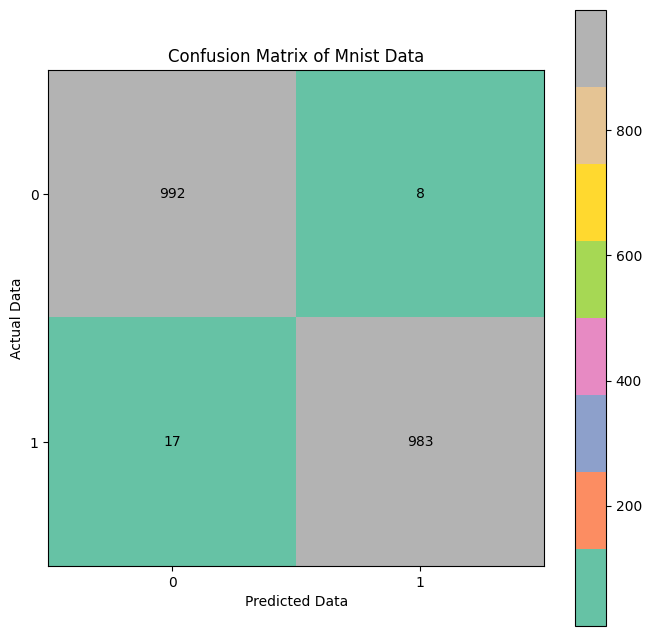

In [24]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Set2")

plt.xticks(np.arange(2))
plt.yticks(np.arange(2))

plt.xlabel("Predicted Data")
plt.ylabel("Actual Data")
plt.colorbar()

plt.title("Confusion Matrix of Mnist Data")

width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y,x), horizontalalignment='center',verticalalignment='center')

Plot to show the models prediction of a specific digit.

For example, in this case we choose target_digit1

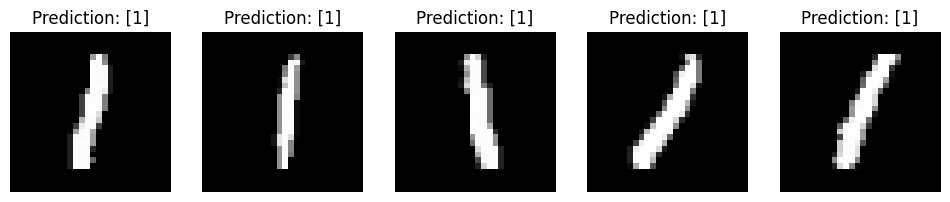

In [25]:
def plot_digit(digit_plot, num_images):
    digit= X_train[y_train == digit_plot]
    data = np.array(digit)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title('Prediction: {}'.format(svm_clf.predict([data[i]])))
    plt.show()
    
    
plot_digit(digit_plot=target_digit1,num_images=5)

<a id='part4.0'></a>
# Part 4: Poisoning Attack

A poisoning attack involves modifying the training data used to train the machine learning model, with the aim of manipulating the model's behavior at test time. This attack can involve adding malicious data or removing important data points from the training set. The objective of a poisoning attack is to compromise the model's accuracy and cause it to make incorrect predictions during testing.

For this lab we followed the research paper:

(https://icml.cc/2012/papers/880.pdf)

Here is the sample diagram explaining poisoning attack.

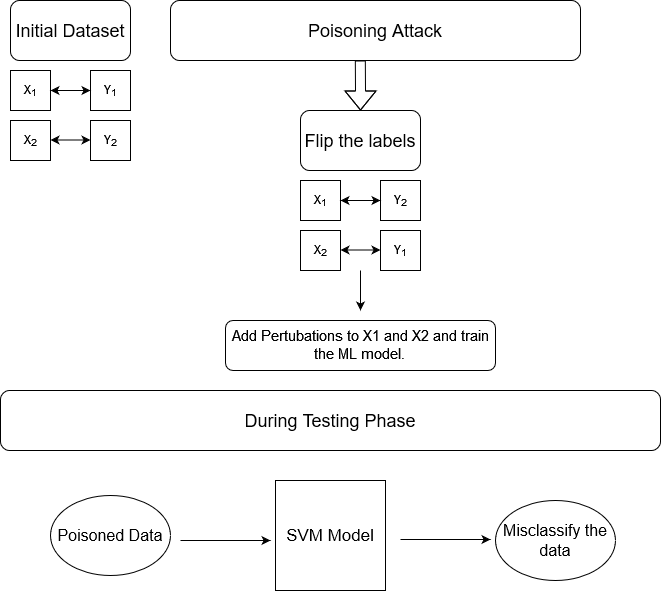

<a id='part4.1'></a>
### 4.1: Data Processing

In order to ensure the data is properly formatted for our poisoning function, we engage in data processing.

As part of this processing, we need to transform our 'y' data into a one-hot encoding.

In [26]:
unique_classes = np.unique(y_train)
nb_samples = len(y_train)
nb_classes = len(unique_classes)
nb_samples_val=len(y_val)
print(unique_classes)
print(nb_samples)

# Create an empty array with the shape (nb_samples, nb_classes)
y_train_ohe = np.zeros((nb_samples, nb_classes))
y_val_ohe=np.zeros((nb_samples_val, nb_classes))

# Fill in the array with the one-hot encoded values
for i, label in enumerate(y_train):
    class_index = np.where(unique_classes == label)[0][0]
    y_train_ohe[i, class_index] = 1
for i, label in enumerate(y_val):
    class_index = np.where(unique_classes == label)[0][0]
    y_val_ohe[i, class_index] = 1

[1 7]
100


<a id='part4.2'></a>
### 4.2: Generating Poisoning Samples

The below block of code is the algorithm mentioned in the reference paper to generate poisoning data.

Add the following code to the **TODO** section to call the poisoning function.

```python
attack = PoisoningAttackSVM(attack_classifier, 0.01, 1.0, x_train, y_train, x_val, y_val, max_iter=20)

```

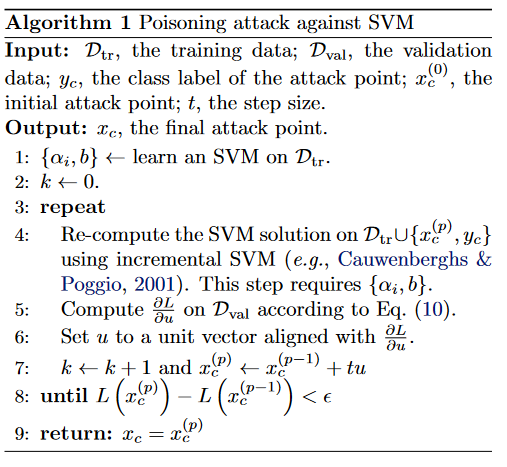

Reference:(https://icml.cc/2012/papers/880.pdf)

where 

"attack classifier" in this context refers to an initialized model used to conduct incremental SVM (Support Vector Machine) as described in the referenced paper.

"learning rate" for gradient ascent function = **0.01**

"epsilon (eps)" refers to a small perturbation or manipulation applied to the input data to craft adversarial examples = **1.0**

Instead of using an infinite loop with while True, the parameter **"max_iter"** specifies the maximum number of iterations to satisfy the condition mentioned in the paper. This ensures that the iterative process terminates after a certain number of iterations, as defined by the value of max_iter

In [27]:
def get_adversarial_examples(x_train, y_train, attack_idx, x_val, y_val, kernel):
    attack_classifier = ScikitlearnClassifierSVC(model=SVC(kernel=kernel),clip_values=(0,255),nb_classes=nb_classes)
    attack_classifier.fit(x_train, y_train)
    init_attack = np.copy(x_train[attack_idx])
    y_attack = np.array([1, 1]) - np.copy(y_train[attack_idx])
    #TODO
    
    x_attack, y_attack = attack.poison(np.array([init_attack]), y=np.array([y_attack]))
    return x_attack,y_attack

In [30]:
num_poisoned_samples=20
x_poison=X_train
y_poison=y_train
for attack_idx in range(num_poisoned_samples):
    x_attackpoint,y_attackpoint = get_adversarial_examples(X_train, y_train_ohe, attack_idx, X_test, y_val_ohe, "linear")
    x_poison=np.concatenate((x_attackpoint,x_poison),axis=0)
    id_array = np.argmax(y_attackpoint, axis=1)
    y_attackpoint=np.where(id_array == 0, 1, 7)
    y_poison=np.concatenate((y_attackpoint,y_poison),axis=0)

SVM poisoning: 1it [00:01,  1.35s/it]
SVM poisoning: 1it [00:01,  1.32s/it]
SVM poisoning: 1it [00:19, 19.93s/it]
SVM poisoning: 1it [00:01,  1.26s/it]
SVM poisoning: 1it [00:03,  3.60s/it]
SVM poisoning: 1it [00:01,  1.24s/it]
SVM poisoning: 1it [00:01,  1.27s/it]
SVM poisoning: 1it [00:01,  1.25s/it]
SVM poisoning: 1it [00:01,  1.35s/it]
SVM poisoning: 1it [00:01,  1.26s/it]
SVM poisoning: 1it [00:01,  1.33s/it]
SVM poisoning: 1it [00:01,  1.40s/it]
SVM poisoning: 1it [00:03,  3.28s/it]
SVM poisoning: 1it [00:01,  1.37s/it]
SVM poisoning: 1it [00:01,  1.23s/it]
SVM poisoning: 1it [00:17, 17.43s/it]
SVM poisoning: 1it [00:03,  3.41s/it]
SVM poisoning: 1it [00:03,  3.38s/it]
SVM poisoning: 1it [00:01,  1.27s/it]
SVM poisoning: 1it [00:01,  1.18s/it]


Let us check if our attack was successful or not

Create a new classifier to assess the misclassification potential of our poisoned data.

In [33]:
svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42)

svm_clf2.fit(x_poison, y_poison)

# Make predictions on the test set
y_pred2 = svm_clf2.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 77.05%


We observe that the classification rate has significantly decreased to less than 80% from 98%, which is an impressive outcome considering the small sample size of 20 instances

The classifier trained on the MNIST dataset has indeed been successfully poisoned, as evident from the observed results. To enhance the attack effectiveness, additional poisoning points can be generated, albeit at the cost of a slower optimization process.

In [34]:
def plot_digit1(x,y, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 8))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(x[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        pre=svm_clf2.predict([x[i]])
        if pre==y[i]:
            label_color='green'
        else:
            label_color='red'
        ax.set_title('Pre: {}'.format(pre), color=label_color)

#### The below plot is to show 10 samples prediction of test data

Out of 10 samples we can see few red labeled samples, indicating the wrong prediction by our model.

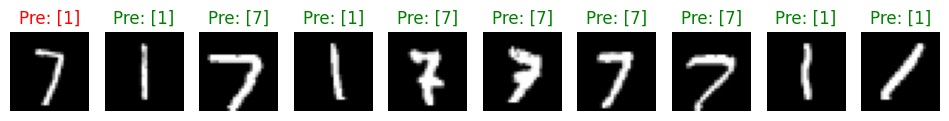

In [37]:
plot_digit1(X_test, y_test,10)

<a id='part5.0'></a>
# Part 5: Defending from Poisoning attack

Defending against poisoning attacks involves implementing countermeasures to mitigate the impact of maliciously manipulated or poisoned data on the machine learning system. Here are a few lines describing the defense strategies against poisoning attacks:

 - **Data sanitization:** One approach to defense is to thoroughly clean and preprocess the training data to identify and remove any potential poisoning or adversarial samples. This can involve outlier detection, anomaly identification, or data validation techniques to filter out suspicious or malicious data points.
 
 **We Performed anomoly detection in our lab using Isolation forest.** Reference: (https://arxiv.org/abs/1802.03041)

 - **Robust model training**: Employing robust machine learning algorithms and techniques can enhance the system's resilience to poisoning attacks. Methods such as ensemble learning, model regularization, and cross-validation can help create models that are more resistant to adversarial manipulation.

    Reference:(https://dl.acm.org/doi/full/10.1145/3574159)
    ****
    

  - **Input validation and filtering**: Implementing strict input validation mechanisms during model deployment can help identify and discard potentially poisoned or malicious inputs. This can involve checking for unusual patterns, data inconsistencies, or suspicious characteristics in the incoming data.
  
      Reference:(https://dl.acm.org/doi/abs/10.1145/3128572.3140450?casa_token=LWM-m8Ct7mEAAAAA:BJH_qdBeyWcoRFUCiAtRvfpMSSBVsdQpT9GakQFtfre3zVaRAVELXulOu2zcOYB4_LYWQrldeYU6)
      ****

   - **Adversarial sample detection**: Employing specialized algorithms or techniques to detect and flag potential adversarial or poisoned samples can assist in identifying and removing them from the training data. This can involve analyzing the model's behavior on specific inputs or leveraging techniques such as anomaly detection or outlier analysis.
   
       Reference:(https://dl.acm.org/doi/abs/10.1145/3128572.3140450?casa_token=LWM-m8Ct7mEAAAAA:BJH_qdBeyWcoRFUCiAtRvfpMSSBVsdQpT9GakQFtfre3zVaRAVELXulOu2zcOYB4_LYWQrldeYU6)
       ****
       

  - **Monitoring and retraining:** Continuously monitoring the performance and behavior of the machine learning system can aid in detecting any signs of poisoning attacks. Regularly retraining the model on updated, clean datasets can help mitigate the impact of potential poisoning and maintain the system's integrity.
  
      Reference: (https://www.sciencedirect.com/science/article/pii/S0167404817302444?casa_token=yqBl34hZdbwAAAAA:p6MGoAbWvzeDISS6JhtXfCj9o-xjie6L3MoHW3wr7Bacl4G7dVw6qq1n3RA8aCXjScaGc-Va)
      ****


It is important to note that no defense strategy can guarantee complete immunity against poisoning attacks, as adversaries constantly adapt their techniques. Therefore, a combination of these defense approaches along with ongoing research and vigilance is necessary to enhance the resilience of machine learning systems to poisoning attacks.

In [41]:
from sklearn.ensemble import IsolationForest


# concatenate original and suspicious data
X_combined = x_poison
y_combined = y_poison

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.2)  # you can adjust the contamination parameter based on your situation
iso_forest.fit(X_combined)

# Predict the anomalies in the data. The method returns 1 for normal data (inliers) and -1 for anomalies (outliers)
outlier_predictions = iso_forest.predict(X_combined)

# Get the inliers data only
X_train_clean = X_combined[outlier_predictions == 1]
y_train_clean = y_combined[outlier_predictions == 1]

svm_clf3 = SVC(kernel='linear', C=1.0, random_state=42)

# Now you can retrain your model with the "clean" data
svm_clf3.fit(X_train_clean, y_train_clean)

SVC(kernel='linear', random_state=42)

In [40]:
y_pred3 = svm_clf3.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred3)
print('Accuracy:', accuracy)

Accuracy: 0.8925


#### An impressive improvement of approximately 10% in the classification rate can be observed, which is considered significant and highly valued in academic settings.

However, it is important to note that more sophisticated and complex attack methods could potentially bypass the defense mechanisms based on anomaly detection. Therefore, while the observed improvement is substantial, it is crucial to remain vigilant and continuously enhance defense strategies to counter more advanced attacks.